From http://docs.pymc.io/notebooks/multilevel_modeling.html.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

from pymc3 import get_data

In [2]:
# Import radon data
srrs2 = pd.read_csv(get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()

In [3]:
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [4]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

This is a row per household.

In [5]:
srrs_mn[:3]

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054


In [6]:
srrs_mn.iloc[0]

idnum                       5081
state                         MN
state2                        MN
stfips                        27
zip                        55735
region                         5
typebldg                       1
floor                          1
room                           3
basement                       N
windoor                         
rep                            2
stratum                        4
wave                          41
starttm                      930
stoptm                       930
startdt                    12088
stopdt                     12288
activity                     2.2
pcterr                       9.7
adjwt                     1146.5
dupflag                        1
zipflag                        0
cntyfips                       1
county      AITKIN              
fips                       27001
Uppm                    0.502054
Name: 0, dtype: object

A lookup table for each county, for indexing.

In [7]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

county_lookup

{'AITKIN': 0,
 'ANOKA': 1,
 'BECKER': 2,
 'BELTRAMI': 3,
 'BENTON': 4,
 'BIG STONE': 5,
 'BLUE EARTH': 6,
 'BROWN': 7,
 'CARLTON': 8,
 'CARVER': 9,
 'CASS': 10,
 'CHIPPEWA': 11,
 'CHISAGO': 12,
 'CLAY': 13,
 'CLEARWATER': 14,
 'COOK': 15,
 'COTTONWOOD': 16,
 'CROW WING': 17,
 'DAKOTA': 18,
 'DODGE': 19,
 'DOUGLAS': 20,
 'FARIBAULT': 21,
 'FILLMORE': 22,
 'FREEBORN': 23,
 'GOODHUE': 24,
 'HENNEPIN': 25,
 'HOUSTON': 26,
 'HUBBARD': 27,
 'ISANTI': 28,
 'ITASCA': 29,
 'JACKSON': 30,
 'KANABEC': 31,
 'KANDIYOHI': 32,
 'KITTSON': 33,
 'KOOCHICHING': 34,
 'LAC QUI PARLE': 35,
 'LAKE': 36,
 'LAKE OF THE WOODS': 37,
 'LE SUEUR': 38,
 'LINCOLN': 39,
 'LYON': 40,
 'MAHNOMEN': 41,
 'MARSHALL': 42,
 'MARTIN': 43,
 'MCLEOD': 44,
 'MEEKER': 45,
 'MILLE LACS': 46,
 'MORRISON': 47,
 'MOWER': 48,
 'MURRAY': 49,
 'NICOLLET': 50,
 'NOBLES': 51,
 'NORMAN': 52,
 'OLMSTED': 53,
 'OTTER TAIL': 54,
 'PENNINGTON': 55,
 'PINE': 56,
 'PIPESTONE': 57,
 'POLK': 58,
 'POPE': 59,
 'RAMSEY': 60,
 'REDWOOD': 61,
 'RENV

Local copies of the variables, for some reason.

This pulls out info from the source dataframe into separate variables. It also creates a few new columns in the dataframe, including a by-integer county field (using the lookup table above) and a field w/ the log of the radon count.

In [8]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

Distribution of radon levels, log scale.

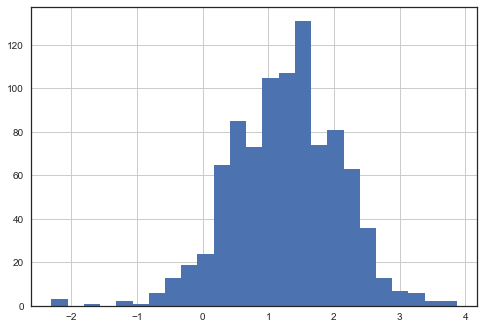

In [9]:
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25);

# Pooled model, "complete pooling"

This treats all counties the same, and estimates a single radon level as a function of whether the measurement was taken in the basement, or above the basement ('floor').

In [10]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform

In [11]:
floor = srrs_mn.floor.values
log_radon = srrs_mn.log_radon.values

In [12]:
with Model() as pooled_model:
    # two beta priors, one for the intercept and one for the slope
    beta = Normal('beta', 0, sd=1e5, shape=2)
    sigma = HalfCauchy('sigma', 5)
    
    # b0 is the intercept, b1 is the coef for the floor indicator variable
    theta = beta[0] + beta[1]*floor

    # the data - log_radon - is distributed using a normal distribution
    # with the mean defined by the regression function defined in 
    # theta above
    y = Normal('y', theta, sd=sigma, observed=log_radon)

In [13]:
with pooled_model:
    pooled_trace = sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 576.75it/s]


In [14]:
b0, m0 = pooled_trace['beta'].mean(axis=0)
b0, m0

(1.3624739217491819, -0.58839489149741631)

The dots are the log radon level, for floor 0 - basement - and floor 1 - first floor/not basement. The line uses the intercept/b0 and slope/m0 numbers that are the mean of the trace from the MCMC run.

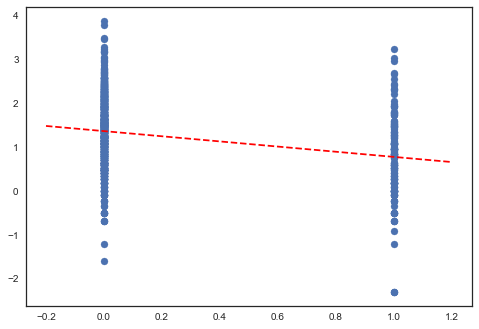

In [15]:
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--');

# No pooling

This runs a separate regression for each of the 85 counties, estimating radon levels again as a function of whether the measurement was taken in the basement or above the basement. Each county gets its own intercept, and the slope is estimated for all counties using all data.

In [16]:
with Model() as unpooled_model:
    beta0 = Normal('beta0', 0, sd=1e5, shape=counties)
    beta1 = Normal('beta1', 0, sd=1e5)
    sigma = HalfCauchy('sigma', 5)
    
    theta = beta0[county] + beta1*floor
    
    y = Normal('y', theta, sd=sigma, observed=log_radon)

In [17]:
with unpooled_model:
    unpooled_trace = sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:05<00:00, 357.59it/s]


In [18]:
from pymc3 import forestplot

I think this is showing us the credible intervals and center for each of the counties/each intercept.

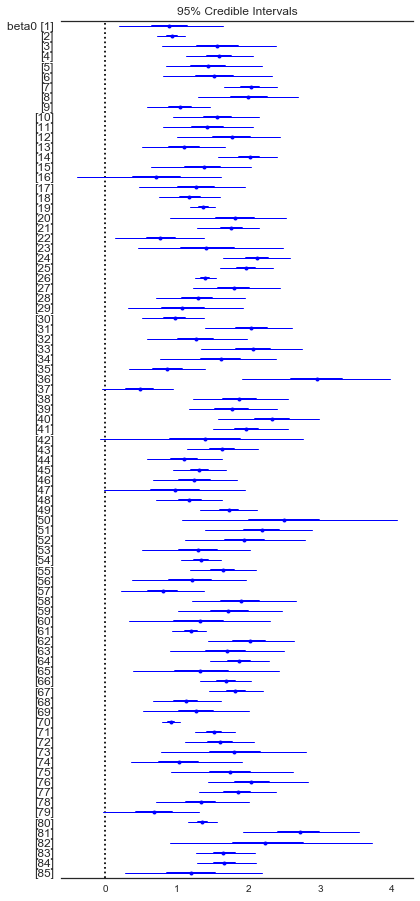

In [19]:
plt.figure(figsize=(6,14))
forestplot(unpooled_trace, varnames=['beta0'])

And, plot the estimates in order to more easily see the counties with high radon levels.

In [20]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=mn_counties)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=mn_counties)

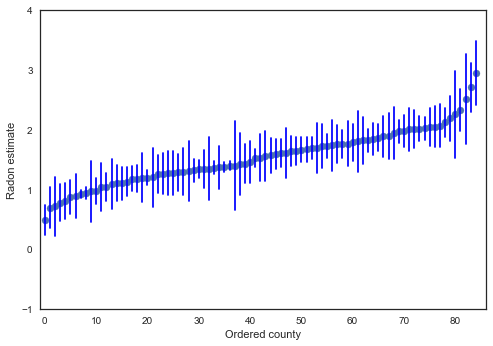

In [21]:
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

Visual comparisons of pooled and unpooled estimates for a subset of the counties (to represent/show a range of sample sizes - observations in that particular county). 

Each observation is shown with a dot - the county on the upper left has only a few observations while the county on the bottom right has many. Pooled is the dashed red line - it's the same for each plot. The individual unpooled estimate is the blue line - it has the same slope in each county, but a different intercept. As a result, it does a better job of fitting the actual observations for each county.

As the page notes, neither works well. If we want to identify high-radon counties, the pooled estimate is useless: information about specific counties is entirely lost when we pool everything. On the other hand, counties that have relatively few observations can easily show extreme county-specific results, which we probably don't trust - see the Lac Qui Parle county in the upper left for example.

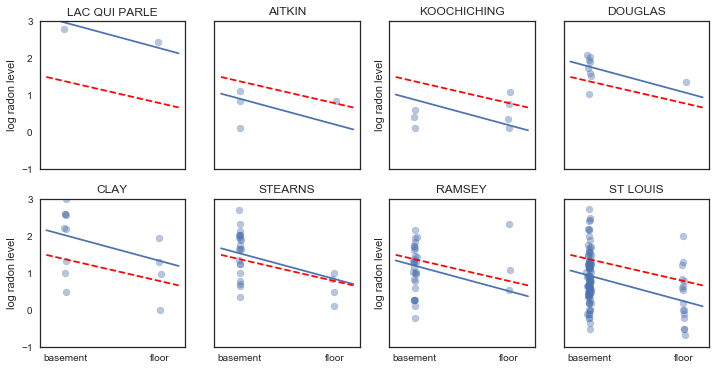

In [22]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING',
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_estimates[c]

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')